In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.spatial.distance import cdist
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

"""WARNING! """
import warnings
warnings.filterwarnings("ignore")


# local imports 
import graph as gr
import utils as ut

In [2]:
# load the data

In [3]:
key = "ND"

dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/graph_data/"
coordpath = f"{dirpath}coordinates.pq"
distpath = f"{dirpath}/distances/{key}_euclidean_distances.pq"
cardpath = f"{dirpath}/global_card_outputs.pq"


cdf = pd.read_parquet(coordpath)
cdf = cdf[cdf['key'] == key].reset_index(drop=True)
print(f"{cdf.shape=}")
print(cdf.head())

D = pd.read_parquet(distpath)
D = D.drop(columns='key')
print(f"{D.shape=}")
print(D.head())

df = pd.read_parquet(cardpath)
print(f"{df.shape=}")
print(df.head())

cdf.shape=(2036, 5)
                  spotId key nodeId            x            y
0  AAACAAGTATCTCCCA.1_ND  ND    1_1  1263.912793  1164.571691
1  AAACAGCTTTCAGAAG.1_ND  ND    1_2   331.221482  1043.233630
2  AAACAGGGTCTATATT.1_ND  ND    1_3   371.414081  1112.975138
3  AAACATTTCCCGGATT.1_ND  ND    1_4  1213.938136  1356.563577
4  AAACCCGAACGAAATC.1_ND  ND    1_5  1394.171280  1077.242752
D.shape=(2071630, 3)
  node1 node2           d
0   1_1   1_2  940.550906
1   1_1   1_3  893.988901
2   1_1   1_4  198.389391
3   1_1   1_5  156.823521
4   1_1   1_6  755.059941
df.shape=(7424, 18)
                    spotId            x            y   key   B cells   
0  AAACAAGTATCTCCCA.1_HFD8  1244.795278  1189.669724  HFD8  0.077635  \
1  AAACACCAATAACTGC.1_HFD8   405.548324  1349.579809  HFD8  0.076987   
2  AAACAGCTTTCAGAAG.1_HFD8   303.880251  1068.178931  HFD8  0.079216   
3  AAACAGGGTCTATATT.1_HFD8   344.496391  1138.478061  HFD8  0.037682   
4  AAACAGTGTTCCTGGG.1_HFD8   648.734268  1595.52458

# Build random neighborhoods

In [4]:
cellTypes = [
    'B cells',
    'Dendritic cells',
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
    'NK cells',
    'Stromal cells',
    'T cells'
]

In [84]:
reload(gr)

# n = len(cdf)
n = 19
r = 52

def feature_similarity(x, y, metric='correlation', as_distance=False):
    """A function to compute feature distances """
    print(f"{x.shape=}")
    print(f"{y.shape=}")
    res = []
    for i, tup in enumerate(zip(x, y)):
        d = scipy.spatial.distance.cdist(tup[0].reshape(1, -1), 
                                         tup[1].reshape(1, -1),
                                         metric=metric)

        if not as_distance:
            d = 1 / np.exp(d) # convert to similarity
            
        res.append(d[0][0])
    return res

nbrhd = gr.get_neighborhood(cdf, 
                            center=True, 
                            n=n, 
                            metric='minkowski')

# subset the edges and coords of the spaitial data
coords = cdf[cdf['nodeId'].isin(nbrhd)].reset_index()
edges = D[(D['node1'].isin(nbrhd)) & (D['node2'].isin(nbrhd))].reset_index(drop=True)    
edges = edges[edges['d'] < r]

card = df[df['nodeId'].isin(nbrhd)]
card = card.set_index('nodeId')

idf = card.loc[edges['node1'], cellTypes]
jdf = card.loc[edges['node2'], cellTypes]

edges['node_similarity'] = feature_similarity(idf.to_numpy(), jdf.to_numpy())
edges['node_similarity'] = edges['node_similarity'].fillna(0)
edges.head()

x.shape=(99, 11)
y.shape=(99, 11)


,node1,node2,d,node_similarity
0,1_13,1_368,40.259781,0.994844
3,1_13,1_701,40.141915,0.998248
5,1_13,1_828,20.070957,0.997326
7,1_13,1_988,34.790658,0.993439
9,1_13,1_1115,34.772267,0.989458


In [6]:
# # plot the landscape
# pdf = edges.copy()

# pdf.head()

(854.27190066926, 951.35400683074, 1102.4677893588398, 1017.95790793716)

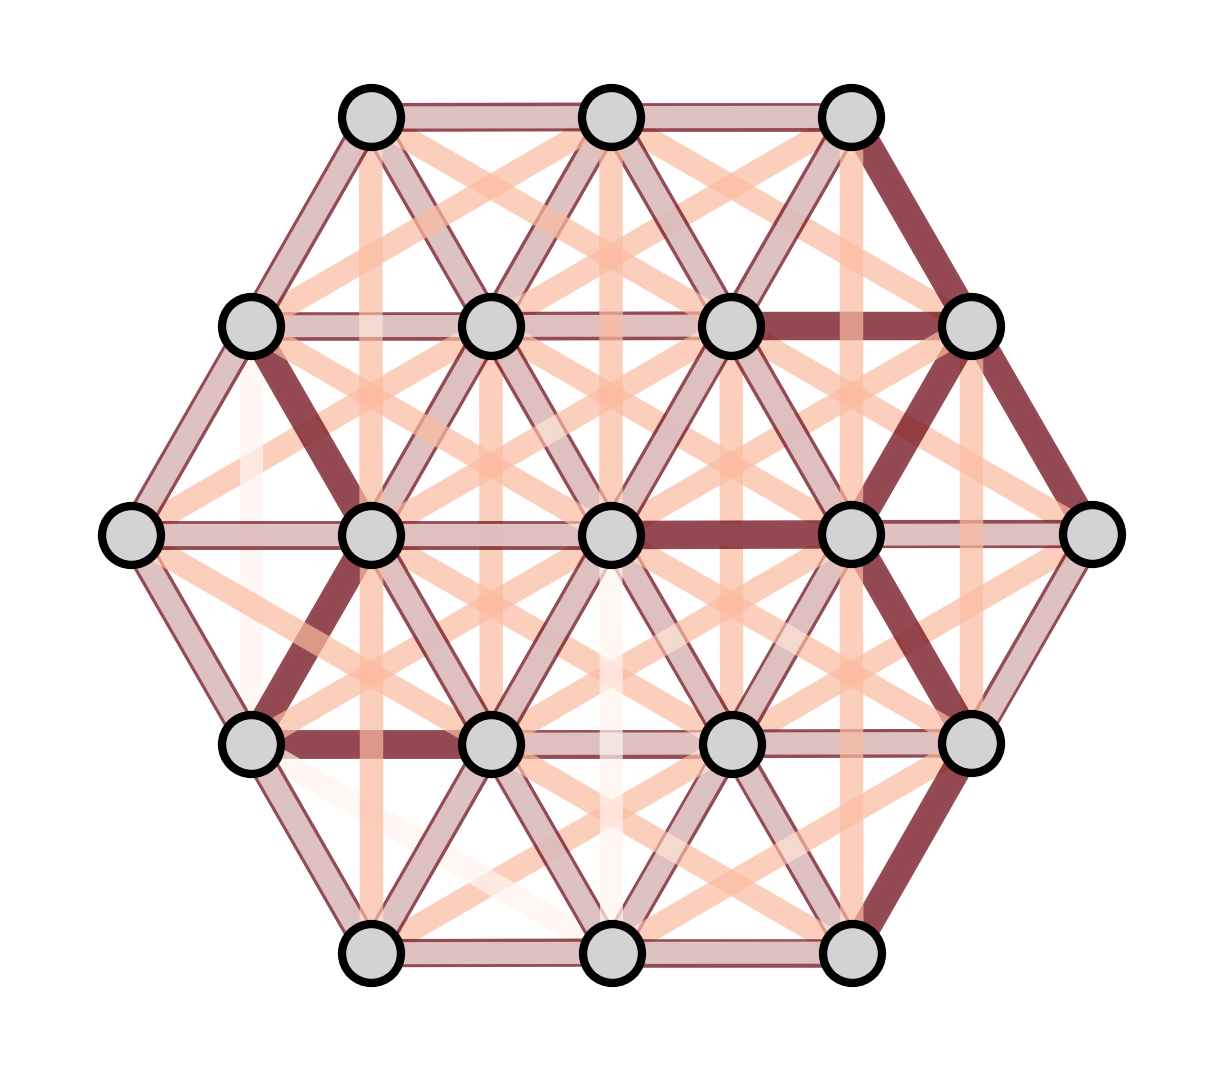

In [105]:
# plot the landscape
pdf = edges.copy()
k = 0.5
pdf['d_inv'] = ( pdf['d']**-k)
pdf['w'] = pdf['node_similarity'] * pdf['d_inv']

color_weight = 'w'

G = gr.build_graph(pdf, coords)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "none"
plt.rcParams['figure.figsize'] = 5, 5

# plotting params
lut = 5
cmap = plt.cm.get_cmap('Reds', lut=lut)
# cmap = plt.cm.get_cmap('RdYlGn', lut=lut)
# cmap = plt.cm.get_cmap('Greys_r', lut=lut)
fig, ax = plt.subplots()

# network plots
nx.draw_networkx_nodes(G,
                       pos=G.pos,
                       node_size=200,
                       # node_color=colors,
                       node_color='lightgrey',
                       # cmap=cmap,
                       # alpha=0.75,
                       edgecolors='k',
                       linewidths=2,
                       ax=ax)

eweights = np.array([e[color_weight] for node1, node2, e in G.edges(data=True)])
eweights = np.array([i/eweights.max() for i in eweights])
eweights =  np.log1p(eweights)

nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=eweights * 10,
                       # edge_color='k',
                       edge_color=eweights,
                       edge_cmap=cmap, 
                       # edge_vmin=0.1, 
                       # edge_vmax=1,
                       alpha=0.7,
                       ax=ax)   


ax.set_aspect('equal')
ax.invert_yaxis()
ax.axis(False)

In [8]:
# metrics

"""Resistance: """


'Resistance: '

In [9]:
# ut.makeColorbar('RdYlGn', 0.3, 2.2, "Correlation", 'vertical', ['Low', 'High'])

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
n = 3
X = np.random.random((n, n))
X = np.dot(X, X.T)
X = X / X.max()
X = X - np.diag(np.diag(X))
# X = X * 30

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "none"
plt.rcParams['figure.figsize'] = 15, 5

fig, axs = plt.subplots(1, 3)

sns.heatmap(X, 
            annot=True,
            fmt=".1f",
            cbar=False,
            square=True,
            cmap='RdYlGn_r',
            ax=axs[0])

axs[0].set_title("X")

Y = np.random.random((n, n))
Y = Y @ Y.T
Y = Y / Y.max()

Y = Y - np.diag(np.diag(Y))

sns.heatmap(Y, 
            annot=True,
            fmt=".1f",
            cbar=False,
            square=True,
            cmap='RdYlGn',
            ax=axs[1],
            )
axs[1].set_title("Y")

A = np.multiply(X, Y)
sns.heatmap(A, 
            annot=True,
            fmt=".1f",
            cbar=False,
            square=True,
            cmap='RdYlGn_r',
            ax=axs[2],
            )

axs[2].set_title("A")

In [ ]:
0.6 * 0.2

In [ ]:
break

In [ ]:
ut.makeColorbar(cmap, 0.3, 3, 'Correlation', 'vertical', ['Low', 'High'])

In [ ]:
break

In [ ]:
df.columns

In [ ]:
# A = nx.adjacency_matrix(G, weight='innate_innate')
# A = A.todense()
# L = scipy.sparse.csgraph.laplacian(A, normed=True)

# fig, axs = plt.subplots(1, 2)
# axs = axs.ravel()

# axs[0].matshow(A)
# axs[1].matshow(L)

# axs[0].set_xticks([])
# axs[0].set_yticks([])
# axs[1].set_xticks([])
# axs[1].set_yticks([])

# plt.tight_layout()